### LOB Simulator


In [44]:
# IMPORTANT CONFIGURATION
# Set to True if you want to rerun the model (be aware if may take ~10 minutes)
# Set to False if you want to use the precomputed model (default)
rerun_model_flag = False

# Set to True if you want to rerun the simulations (be aware if may take ~10 minutes)
# Set to False if you want to use the precomputed simulations (default)
rerun_simulations_flag = True

# Set to True if you want to rerun the hyperparameter tuning (be aware if may take ~20 minutes)
# Set to False if you want to use the precomputed hyperparameter tuning (default)
rerun_hyperparam_tuning_flag = False

In [1]:
# Consolidated import statements
import sys
sys.path.append("../")  # Add repo path

# Standard
import os
import re
import shutil
import time
import warnings
import multiprocessing as mp
from copy import deepcopy
from pathlib import Path
from multiprocessing import Pool, cpu_count

# Cleaner output
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm 
from dotenv import load_dotenv

# RL
import torch
import optuna
import gym
from optuna.pruners import BasePruner, MedianPruner, PercentilePruner
from optuna.trial import FrozenTrial, TrialState
from optuna.study import Study
import optuna.visualization as vis
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.metrics import mean_squared_error

# MBT Gym imports
from mbt_gym.gym.wrappers import ReduceStateSizeWrapper
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.gym.helpers.visualize_return import *
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.index_names import *
from mbt_gym.agents.SbAgent import SbAgent
from mbt_gym.agents.BaselineAgents import *
from env_utils import *
from metric_utils import *

print("All imports successfully consolidated.")

All imports successfully consolidated.


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)  # Fix for CUDA multiprocessing


## Example Environment 

Seed in this run:  9627070


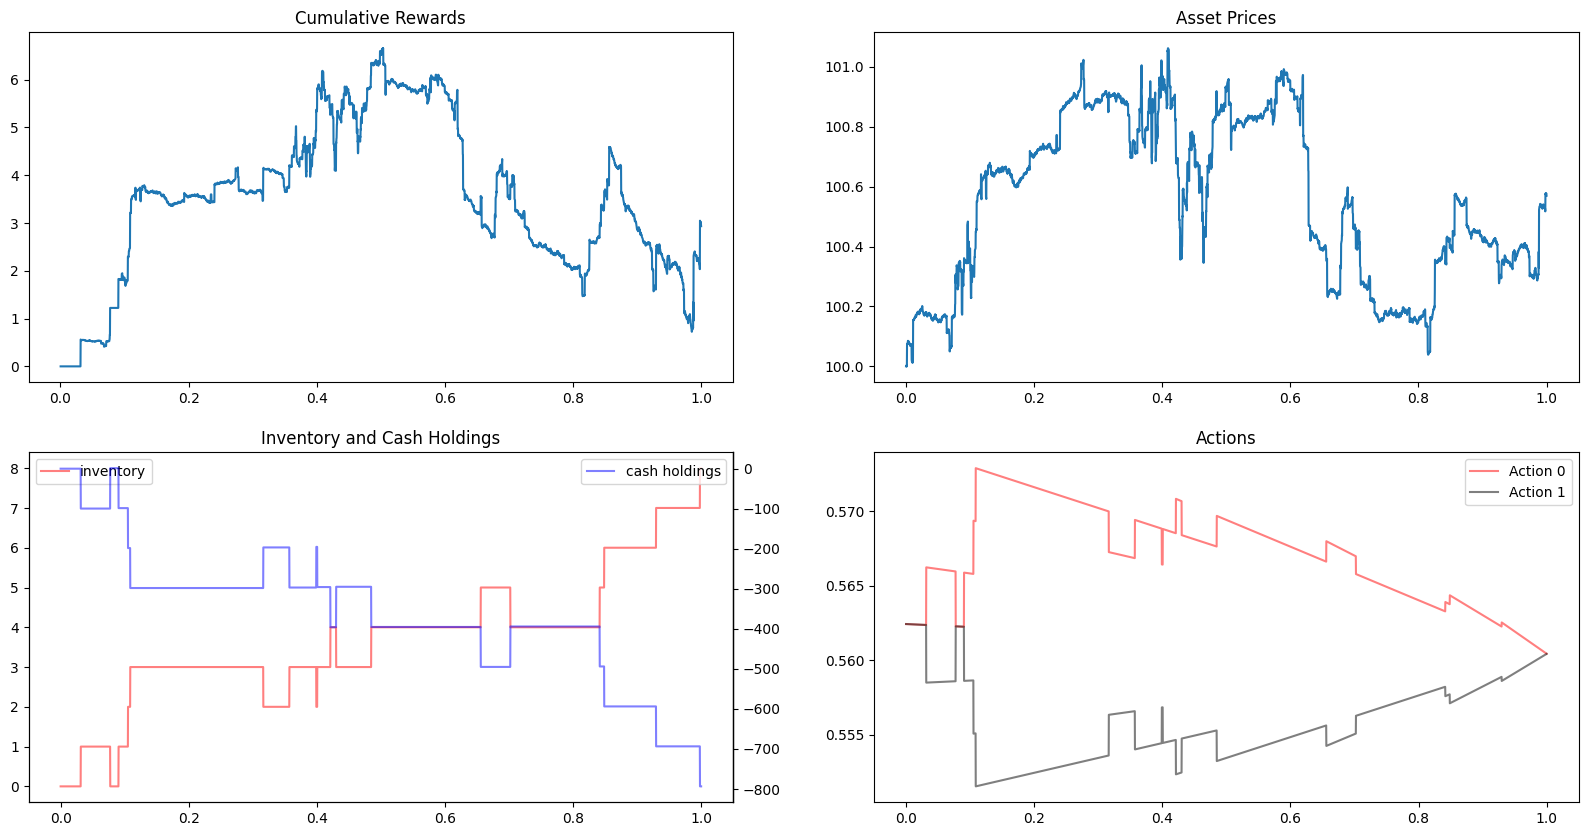

In [7]:
seed = np.random.randint(0, 10000000)
print("Seed in this run: ", seed)

my_env = get_env_myModel()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=my_env)

as_mid_series_my, _ = plot_trajectory(my_env, as_agent, seed = seed)

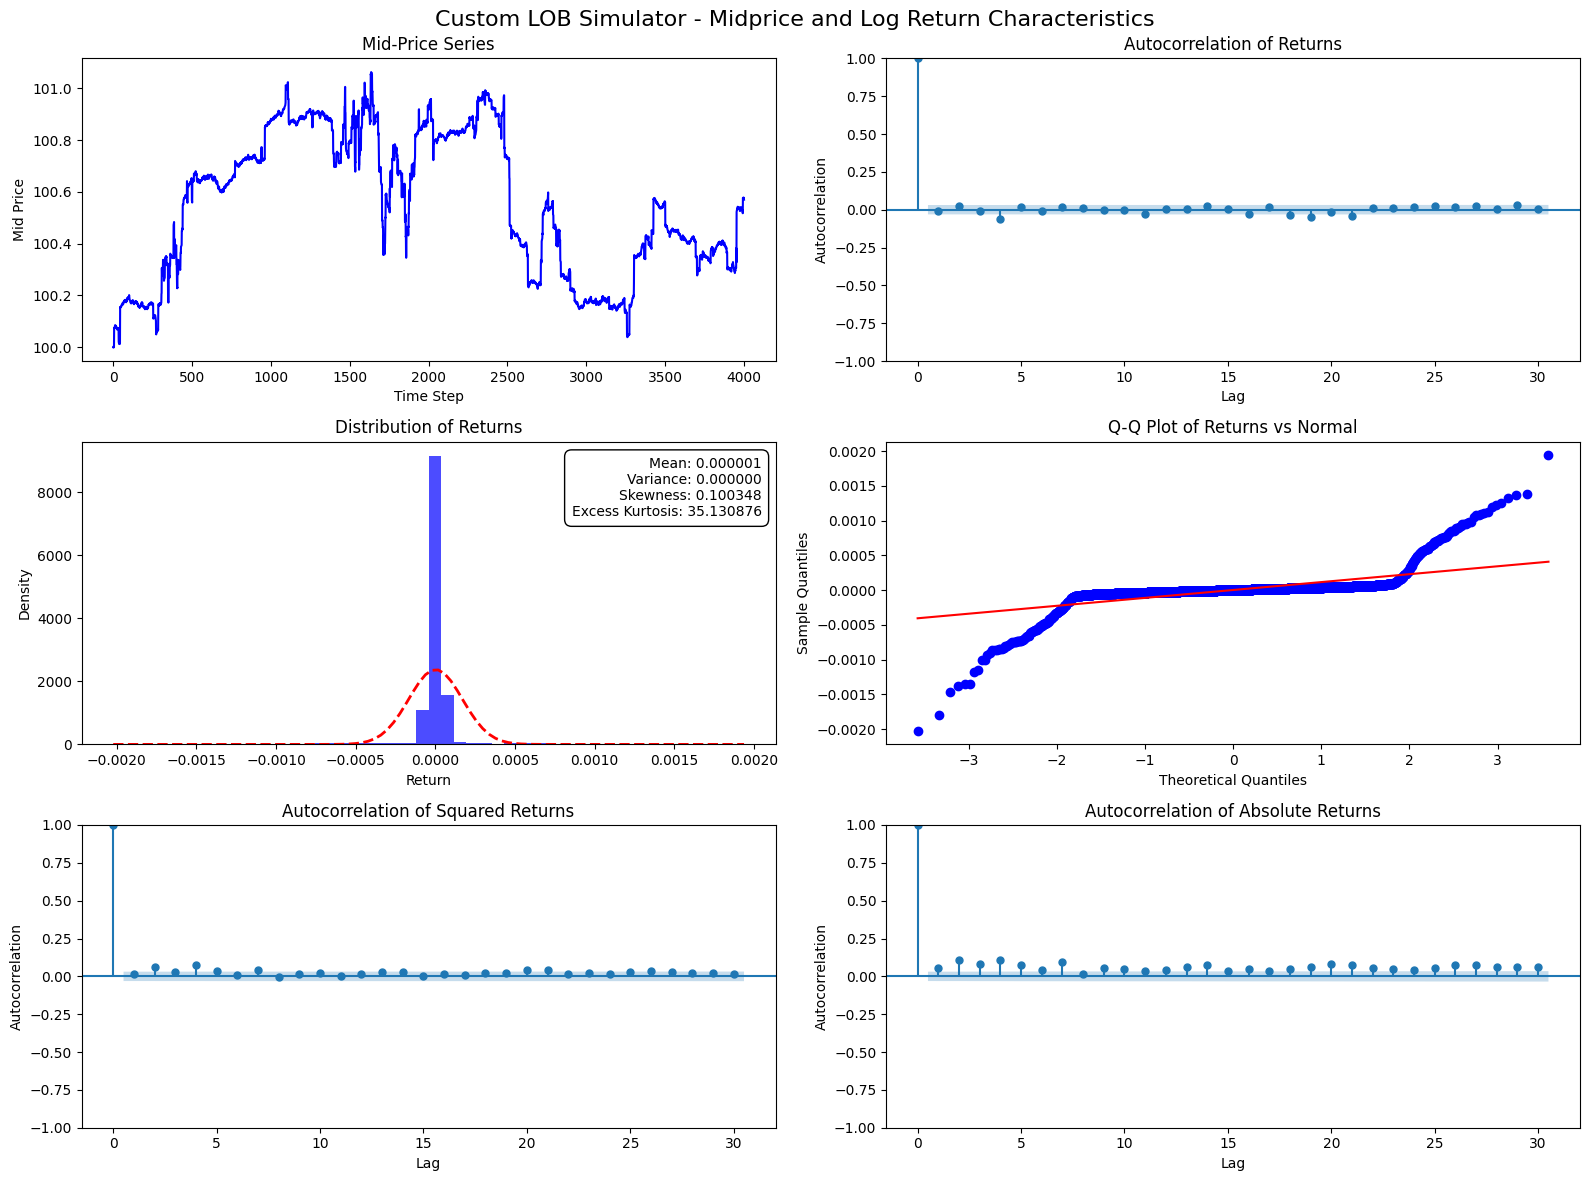

In [8]:
visualize_return(as_mid_series_my, "Custom LOB Simulator - Midprice and Log Return Characteristics")

### RL Training & Hyperparameter Tuning

List of RL Algorithms

- A2C 
- PPO 
- SAC 


In [9]:
tensorboard_logdir = "./tensorboard/"
best_model_path = "./SB_models/"

if rerun_model_flag:
    # Clear destination folder before each run
    shutil.rmtree(tensorboard_logdir, ignore_errors=True)
    shutil.rmtree(best_model_path, ignore_errors=True)

    # Make new directories
    Path(tensorboard_logdir).mkdir(parents=True, exist_ok=True)
    Path(best_model_path).mkdir(parents=True, exist_ok=True)
else:
    print("Skipping model rerun.")

Skipping model rerun.


In [ ]:
# Adjusted parameters for faster training
terminal_time = 1.0
n_steps = 200 
num_trajectories = 2000  # mbt-gym parallel trajectories
total_timesteps = 20_000_000  # Reduced total training timesteps

# EvalCallback parameters
n_eval_episodes = 30  # Evaluation episodes
eval_freq = 500000  # More frequent evaluations with fewer steps

training_time_dict = {}

In [11]:
env = ReduceStateSizeWrapper(get_env_myModel(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)
sb_env = VecMonitor(sb_env)

In [12]:
PPO_tensorboard_logdir = tensorboard_logdir + "PPO-learning/"
PPO_best_model_path = Path(best_model_path) / "PPO_best_model"

PPO_callback = EvalCallback(eval_env=sb_env, n_eval_episodes=n_eval_episodes, 
                             eval_freq=eval_freq, deterministic=True)

ppo_model = PPO("MlpPolicy", sb_env, verbose=0, tensorboard_log=PPO_tensorboard_logdir, device=device,
                n_steps=n_steps, batch_size=int(n_steps * num_trajectories / 20))  # Adjusted batch size

print("PPO Setup successful. Starting training.")

if rerun_model_flag:
    start = time.time()
    ppo_model.learn(total_timesteps=total_timesteps, callback=PPO_callback)
    end = time.time()
    training_time_dict["PPO"] = end - start
    print("PPO Training completed successfully.")

    ppo_model.save(PPO_best_model_path)
    assert PPO_best_model_path.with_suffix(".zip").exists(), "Model not saved correctly."
else:
    ppo_model = PPO.load(PPO_best_model_path.with_suffix(".zip"))
    print("Skipping model training. Loading precomputed model.")

    assert ppo_model is not None, "Model not loaded correctly."


PPO Setup successful. Starting training.
Skipping model training. Loading precomputed model.


In [13]:
# A2C Setup
A2C_tensorboard_logdir = tensorboard_logdir + "A2C-learning/"
A2C_best_model_path = Path(best_model_path) / "A2C_best_model"

A2C_callback = EvalCallback(eval_env=sb_env, n_eval_episodes=n_eval_episodes, 
                             eval_freq=eval_freq, deterministic=True)

a2c_model = A2C("MlpPolicy", sb_env, verbose=0, tensorboard_log=A2C_tensorboard_logdir,device=device,
                n_steps=n_steps)  # A2C does not use batch_size

print("A2C Setup successful. Starting training.")

if rerun_model_flag:
    start = time.time()
    a2c_model.learn(total_timesteps=total_timesteps, callback=A2C_callback)
    end = time.time()
    training_time_dict["A2C"] = end - start
    print("A2C Training completed successfully.")

    a2c_model.save(A2C_best_model_path)
    assert os.path.exists(A2C_best_model_path.with_suffix(".zip")), "Model not saved correctly."
else:
    a2c_model = A2C.load(A2C_best_model_path.with_suffix(".zip"))
    print("Skipping model training. Loading precomputed model.")

    assert a2c_model is not None, "Model not loaded correctly."
    


A2C Setup successful. Starting training.
Skipping model training. Loading precomputed model.


In [14]:
# SAC Setup
SAC_tensorboard_logdir = tensorboard_logdir + "SAC-learning/"
SAC_best_model_path = Path(best_model_path) / "SAC_best_model"

SAC_callback = EvalCallback(eval_env=sb_env, n_eval_episodes=n_eval_episodes, 
                             eval_freq=eval_freq, deterministic=True)

sac_model = SAC("MlpPolicy", sb_env, verbose=0, tensorboard_log=SAC_tensorboard_logdir, device=device)

print("SAC Setup successful. Starting training.")
if rerun_model_flag:
    start = time.time()
    sac_model.learn(total_timesteps=total_timesteps, callback=SAC_callback)
    end = time.time()
    training_time_dict["SAC"] = end - start
    print("SAC Training completed successfully.")

    sac_model.save(SAC_best_model_path)
    assert os.path.exists(SAC_best_model_path.with_suffix(".zip")), "Model not saved correctly."
else:
    sac_model = SAC.load(SAC_best_model_path.with_suffix(".zip"))
    print("Skipping model training.")

    assert sac_model is not None, "Model not loaded correctly."

SAC Setup successful. Starting training.
Skipping model training.


In [15]:
print("Training times for each model:")
print(training_time_dict)

Training times for each model:
{}


## Investigating Performance of RL Agents

`generate_trajectory` returns:
- observations (np.ndarray): Shape (num_trajectories, obs_dim, n_steps + 1).
    Example: (1, 6, 4001), where:
    - Index 0: Cash holdings
    - Index 1: Inventory
    - Index 2: Time
    - Index 3: Asset price
    - Index 4 & 5: Additional (unspecified) features
- actions (np.ndarray): Shape (num_trajectories, action_dim, n_steps),
    representing bid and ask actions per timestep.
- rewards (np.ndarray): Shape (num_trajectories, 1, n_steps),
    representing rewards at each timestep.

In [ ]:
SIMULATION_RUNS = 1000 

In [ ]:
def collect_metrics(model_type, model_path, agent_params, env_config, hyperparams, num_runs=100):
    """Parallelized version of the metric collection process with real-time progress tracking."""
    num_processes = min(cpu_count() - 3, num_runs)
    num_processes = max(num_processes, 1)  # Ensure at least one process

    print(f"Starting metric collection for {num_runs} episodes using {num_processes} parallel processes...")
    start_time = time.time()

    #  Prepare argument list
    args_list = [
        (model_type, model_path, agent_params, env_config, hyperparams, np.random.randint(0, 10000000))
        for _ in range(num_runs)
    ]

    with Pool(processes=num_processes) as pool:
        results, failed_runs = [], []
        completed_runs = 0  # Track completed runs

        for i, result in enumerate(pool.imap_unordered(run_single_episode, args_list)):
            try:
                results.append(result)
                completed_runs += 1  #  Increment completed count
                print(f"[INFO] {completed_runs}/{num_runs} subprocesses completed...", end="\r")  #  Real-time update
            except Exception as e:
                failed_runs.append(i)  # Track which runs failed
                print(f"[ERROR] Failed execution {i}: {e}")

    #  Convert results to NumPy array
    results = np.array([r for r in results if r is not None])  # Remove failed runs

    #  Convert to DataFrame for easier storage & analysis
    raw_results_df = pd.DataFrame(results, columns=[
        "terminal_reward", "avg_abs_inventory", "raw_terminal_inventory", "abs_terminal_inventory"
    ])
    
    #  SAVE RAW RESULTS as CSV for further analysis
    raw_results_file = f"{model_type}_raw_metrics_results.csv"
    raw_results_df.to_csv(raw_results_file, index=False)

    #  Compute aggregate statistics across runs
    metrics = {
        "mean_terminal_reward": np.mean(results[:, 0]),
        "std_terminal_reward": np.std(results[:, 0]),
        "mean_avg_abs_inventory": np.mean(results[:, 1]),
        "mean_abs_terminal_inventory": np.mean(results[:, 3]),
        "std_abs_terminal_inventory": np.std(results[:, 3]),
        "mean_raw_terminal_inventory": np.mean(results[:, 2]),
        "all_rewards_series": results[:, 0],
        "all_avg_abs_inventory_series": results[:, 1],
        "all_raw_terminal_inventory_series": results[:, 2],
        "all_abs_terminal_inventory_series": results[:, 3],
    }

    elapsed_time = time.time() - start_time
    print(f"\nMetric collection completed in {elapsed_time:.2f} seconds.")

    return metrics




In [18]:
def save_metrics(all_metrics, file_path, remove=False):
    try:
        all_metrics_df = pd.DataFrame(all_metrics)

        # Ignore metrics begining with "all_"
        # They are not needed for the final report
        all_metrics_df = all_metrics_df.loc[:, ~all_metrics_df.columns.str.startswith("all_")]

        if remove:
            # Overwrite the file
            all_metrics_df.to_csv(file_path, index=False)
        else:
            # Append to the existing file
            file_exists = os.path.exists(file_path)
            all_metrics_df.to_csv(file_path, mode='a', header=not file_exists)
    except Exception as e:
        print(f"Error saving metrics: {e}")

def load_metrics(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} does not exist.")
    try:
        df = pd.read_csv(file_path)
        print("Metrics loaded successfully.")

        # Change the first column name to Metric
        df.rename(columns={df.columns[0]: "Metric"}, inplace=True)
        return df
    except Exception as e:
        print(f"Error loading metrics: {e}")
        raise

In [ ]:
assert PPO_best_model_path.with_suffix(".zip").exists(), "PPO model not saved correctly."
PPO.load(PPO_best_model_path.with_suffix(".zip"))

In [20]:
hyperparams_ppo = {
    "verbose": 0,
    "tensorboard_log": PPO_tensorboard_logdir,
    "device": device,
    "n_steps": n_steps,
    "batch_size": int(n_steps * num_trajectories / 20)
}

hyperparams_a2c = {
    "verbose": 0,
    "tensorboard_log": A2C_tensorboard_logdir,
    "device": device,
    "n_steps": n_steps
}

hyperparams_sac = {
    "verbose": 0,
    "tensorboard_log": SAC_tensorboard_logdir,
    "device": device
}

# --- Define agent-specific parameters ---
agent_params = {
    "num_trajectories": 1,
    "reduced_training_indices": [INVENTORY_INDEX, TIME_INDEX]
}

# --- Define agents and their corresponding models and paths ---
agents = [
    ("Avellaneda-Stoikov", None, None, None), 
    ("PPO", PPO_best_model_path.with_suffix(".zip"), hyperparams_ppo, agent_params),
    ("SAC", SAC_best_model_path.with_suffix(".zip"), hyperparams_sac, agent_params),
    ("A2C", A2C_best_model_path.with_suffix(".zip"), hyperparams_a2c, agent_params)
]

# --- Dictionary to store metrics for each agent ---
all_metrics = {}
all_metrics_df = None
all_metrics_df_file_path = "all_metrics.csv"

# --- Running simulations if enabled ---
if rerun_simulations_flag:
    for model_type, model_path, hyperparams, agent_params in agents:
        print(f"\nCollecting metrics for {model_type}...")
        
        # Collect metrics over n runs
        agent_metrics = collect_metrics(model_type, model_path, agent_params, my_env, hyperparams, num_runs=SIMULATION_RUNS)
        all_metrics[model_type] = agent_metrics

    save_metrics(all_metrics, all_metrics_df_file_path, index=False, remove=True) 
    all_metrics_df = pd.DataFrame(all_metrics)  # Or load it back if needed
else:
    print("Disabled rerun_simulations_flag. Skipping simulations.")
    print("Loading precomputed metrics.")
    all_metrics_df = load_metrics(all_metrics_df_file_path)

Disabled rerun_simulations_flag. Skipping simulations.
Loading precomputed metrics.
Metrics loaded successfully.


In [21]:
all_metrics_df


,Metric,Avellaneda-Stoikov,PPO,SAC,A2C,PPO_Tuned,SAC_Tuned
0,mean_terminal_reward,8.004787,13.404908,12.840375,5.573524,11.629037,12.844654
1,std_terminal_reward,9.036564,8.121530,7.566263,16.323936,8.182689,7.503113
2,mean_avg_abs_inventory,2.380764,1.307556,0.976640,1.882528,1.963856,1.023353
3,mean_abs_terminal_inventory,3.798000,2.059000,1.624000,2.769000,3.248000,1.740000
4,std_abs_terminal_inventory,3.076231,1.988346,1.380806,3.647690,2.708227,1.429126
...,...,...,...,...,...,...,...
169,mean_avg_abs_inventory,1.029717,NaN,NaN,NaN,NaN,NaN
170,mean_raw_terminal_inventory,0.100000,NaN,NaN,NaN,NaN,NaN
171,mean_terminal_reward,13.156688,NaN,NaN,NaN,NaN,NaN
172,std_abs_terminal_inventory,1.509246,NaN,NaN,NaN,NaN,NaN


In [22]:
# Make sure plotting works but does not interfere with the rest of the code
am_copy = pd.read_csv("FINAL_METRICS.csv")

# IF column has keyword 'Tuned', remove it
keyword_to_remove = 'Tuned'
for col in am_copy.columns:
    if keyword_to_remove in col:
        am_copy.drop(col, axis=1, inplace=True) 

am_copy.rename(columns={
    col: re.sub(r'SAC_Tuned_Alpha(\d+)', lambda m: f'$\\alpha={m.group(1)}$', col)
    for col in am_copy.columns
}, inplace=True)


am_copy

,Metric,Avellaneda-Stoikov,PPO,SAC,A2C
0,mean_terminal_reward,8.004787,13.404908,12.840375,5.573524
1,std_terminal_reward,9.036564,8.121530,7.566263,16.323936
2,mean_avg_abs_inventory,2.380764,1.307556,0.976640,1.882528
3,mean_abs_terminal_inventory,3.798000,2.059000,1.624000,2.769000
4,std_abs_terminal_inventory,3.076231,1.988346,1.380806,3.647690
5,mean_raw_terminal_inventory,0.186000,-0.283000,-0.012000,-0.979000


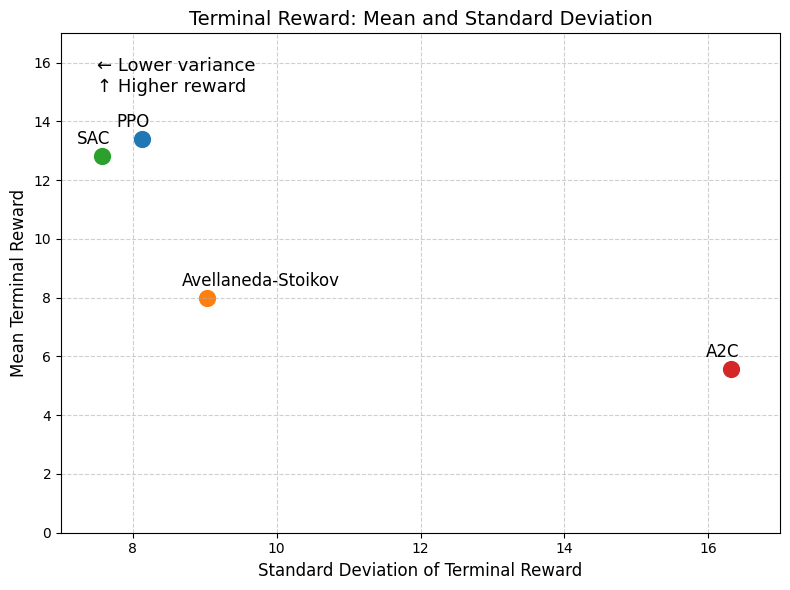

In [ ]:
# Set Metric to be the index
if "Metric" in am_copy.columns:
    am_copy.set_index("Metric", inplace=True)

# Extract data
x1 = am_copy.loc['std_terminal_reward']
y1 = am_copy.loc['mean_terminal_reward']

# Define color palette
colors = {
    "PPO": "#1f77b4",
    "SAC": "#2ca02c",
    "Avellaneda-Stoikov": "#ff7f0e",
    "A2C": "#d62728"
}

# Create figure
plt.figure(figsize=(8, 6))
for model in am_copy.columns:
    plt.scatter(x1[model], y1[model], label=model, color=colors.get(model, 'gray'), s=130)
    plt.text(x1[model] - 0.35, y1[model] + 0.4, model, fontsize=12)

# Aesthetics
plt.xlabel("Standard Deviation of Terminal Reward", fontsize=12)
plt.ylabel("Mean Terminal Reward", fontsize=12)
plt.title("Terminal Reward: Mean and Standard Deviation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(7,17)
plt.ylim(0, 17)

plt.annotate("← Lower variance\n↑ Higher reward", xy=(7.5, 15.0), fontsize=13)


plt.tight_layout()
plt.show()


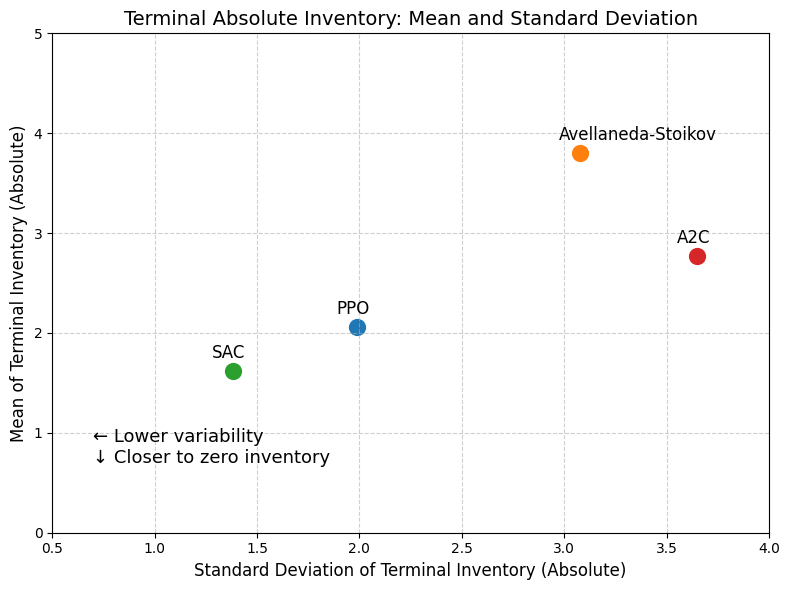

In [24]:
# Second plot: std_abs_terminal_inventory vs mean_abs_terminal_inventory
x2 = am_copy.loc['std_abs_terminal_inventory']
y2 = am_copy.loc['mean_abs_terminal_inventory']

plt.figure(figsize=(8, 6))

# Optional: consistent color mapping like the reward plot
colors = {
    "PPO": "#1f77b4",
    "SAC": "#2ca02c",
    "Avellaneda-Stoikov": "#ff7f0e",
    "A2C": "#d62728"
}

for model in am_copy.columns:
    plt.scatter(x2[model], y2[model], label=model, color=colors.get(model, 'gray'), s=130)
    plt.text(x2[model] - 0.1, y2[model] + 0.13, model, fontsize=12)

# Axis labels
plt.xlabel("Standard Deviation of Terminal Inventory (Absolute)", fontsize=12)
plt.ylabel("Mean of Terminal Inventory (Absolute)", fontsize=12)

# Updated, more descriptive title
plt.title("Terminal Absolute Inventory: Mean and Standard Deviation", 
          fontsize=14)

plt.annotate("← Lower variability\n↓ Closer to zero inventory", 
             xy=(0.7, 0.7), 
             fontsize=13
             )


plt.xlim(0.5,4)
plt.ylim(0,5)

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Reward vs erisk 2d plot for reqrsd and terminal inventiry

full distribution (reward)

replicat initial mbt_gym plot

vary alpha 0,1 0.5

## Hyperparameter tuning for PPO and SAC

In [ ]:
# Tuning parameters
NUM_TRAILS = 150 # Number of parameter combinations to try
NUM_RUNS_FOR_METRICS = 300 # Number of runs to collect metrics

alpha = 0.3 # Risk_aversion moderating coefficient in the tuning objective function


In [ ]:
load_dotenv()  # Load from .env file

def get_postgres_url(agent: str):
    agent = agent.upper()
    user = os.getenv(f"PSQL_{agent}_USER")
    password = os.getenv(f"PSQL_{agent}_PASSWORD")
    host = os.getenv(f"PSQL_{agent}_HOST", "localhost")
    port = os.getenv(f"PSQL_{agent}_PORT", "5432")
    db = os.getenv(f"PSQL_{agent}_DB")
    
    return f"postgresql://{user}:{password}@{host}:{port}/{db}"

postgres_sac_url = get_postgres_url("sac")
sac_storage = optuna.storages.RDBStorage(url=postgres_sac_url)

In [ ]:
# --- Custom Pruner with Startup Trial Guard ---
class ThresholdPruner(BasePruner):
    def __init__(self, threshold, n_startup_trials=3):
        self.threshold = threshold
        self.n_startup_trials = n_startup_trials

    def prune(self, study: Study, trial: FrozenTrial) -> bool:
        if len(study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))) < self.n_startup_trials:
            return False

        step = trial.last_step
        if step is None or step not in trial.intermediate_values:
            return False

        val = trial.intermediate_values[step]
        if study.direction == optuna.study.StudyDirection.MINIMIZE:
            return val > self.threshold
        else:
            return val < self.threshold  # MAXIMIZE


# --- Combined Pruner ---
class CombinedPruner(BasePruner):
    def __init__(self, *pruners):
        self.pruners = pruners

    def prune(self, study: Study, trial: FrozenTrial) -> bool:
        return any(pruner.prune(study, trial) for pruner in self.pruners)
    
# Create individual pruners
percentile_pruner = PercentilePruner(percentile=30.0, n_startup_trials=3, interval_steps=1)
threshold_pruner = ThresholdPruner(threshold=-2.0, n_startup_trials=3)

# Combine them
combined_pruner = CombinedPruner(
    percentile_pruner,
    threshold_pruner
)

In [ ]:
def objective_sac_composite(trial):
    """
    Objective function for Optuna tuning: trains SAC and evaluates using a composite metric.
    Composite = mean_terminal_reward - alpha * avg_abs_inventory
    """
    # Top 3–4 SAC hyperparameters to tune
    gamma = trial.suggest_float("gamma", 0.95, 0.9995)
    learning_rate = trial.suggest_float("learning_rate", 5e-5, 2e-3, log=True)
    tau = trial.suggest_float("tau", 0.002, 0.03)
    ent_coef = trial.suggest_categorical("ent_coef", ["auto", 0.0001, 0.0003, 0.001, 0.01]) # Auto or fixed values

    # Print tuned parameters for transparency
    print(f"Trial with gamma={gamma}, learning_rate={learning_rate}, tau={tau}, ent_coef={ent_coef}")

    # Instantiate SAC model with tuned + default hyperparameters
    sac_model = SAC(
        "MlpPolicy", sb_env, device=device,
        gamma=gamma,
        learning_rate=learning_rate,
        tau=tau,
        ent_coef=ent_coef,
        verbose=0
    )

    total_timesteps =  20_000_000   # Full training timesteps
    evaluation_steps = [7_000_000, total_timesteps]   # no pruning as evaluation is very expensive
    cumulative_steps = 0
    reset_flag = True

    # Incremental training with evaluations and pruning reports
    for step in evaluation_steps:
        new_timesteps = step - cumulative_steps  # Only train the difference
        cumulative_steps += new_timesteps

        sac_model.learn(total_timesteps=new_timesteps, reset_num_timesteps=reset_flag)

        # Save model after each training phase
        sac_intermediate_model_path = Path(best_model_path) / f"SAC_intermediate_model_{cumulative_steps}"
        sac_model.save(sac_intermediate_model_path)

        reset_flag = False

        hyperparams = {}  # No need to save hyperparameters as they are already saved in the model

        # def collect_metrics(model_type, model_path, agent_params, env_config, hyperparams, num_runs=100):
        metrics = collect_metrics('SAC', sac_intermediate_model_path.with_suffix(".zip"), agent_params, my_env, hyperparams, num_runs=NUM_RUNS_FOR_METRICS)

        mean_terminal_reward = metrics["mean_terminal_reward"]
        avg_abs_inventory = metrics["mean_avg_abs_inventory"]

        # Print raw metrics for examination
        print(f"After {cumulative_steps} timesteps: mean_terminal_reward = {mean_terminal_reward}, "
              f"avg_abs_inventory = {avg_abs_inventory}")

        # Compute composite metric
        composite_metric = mean_terminal_reward - alpha * avg_abs_inventory

        # Report composite metric for pruning
        trial.report(composite_metric, cumulative_steps)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Final raw metrics
    print(f"Final raw metrics: mean_terminal_reward = {mean_terminal_reward}, "
          f"avg_abs_inventory = {avg_abs_inventory}")
    composite_metric = mean_terminal_reward - alpha * avg_abs_inventory
    return composite_metric


# -------------------------------
# Main tuning and saving logic for SAC:
if rerun_hyperparam_tuning_flag:
    # Create a study with single objective optimization and a MedianPruner for SAC
    study_sac_reward = optuna.create_study(direction="maximize", 
                                           pruner=combined_pruner,
                                           study_name=f"SAC_Composite_Metric_Study_Alpha={alpha}",
                                           storage=sac_storage,
                                           load_if_exists=True)
    study_sac_reward.optimize(objective_sac_composite, n_trials=NUM_TRAILS)

    # Save best hyperparameters and metrics to CSV for SAC
    best_params_sac = study_sac_reward.best_params
    best_value_sac = study_sac_reward.best_value

    print(f"Best trial found: Composite Metric = {best_value_sac}")
    print(f"With parameters: {best_params_sac}")

    best_params_sac["best_composite_metric"] = best_value_sac
    best_params_df_sac = pd.DataFrame([best_params_sac])
    best_params_sac_path = "best_params_sac.csv"
    if os.path.exists(best_params_sac_path):
        os.remove(best_params_sac_path)
    best_params_df_sac.to_csv(best_params_sac_path, index=False)
    print("Best hyperparameters saved to best_params_sac.csv")
else:
    print("Skipping hyperparameter tuning. Loading precomputed results.")

    best_params_sac_path = "best_params_sac.csv"
    if not os.path.exists(best_params_sac_path):
        raise FileNotFoundError(f"Error: '{best_params_sac_path}' not found. Please run hyperparameter tuning first.")

    best_params_df_sac = pd.read_csv(best_params_sac_path)
    best_params_sac = best_params_df_sac.to_dict(orient="records")[0]

    excluded_keys = ["best_composite_metric"]
    hyperparams_sac = {k: v for k, v in best_params_sac.items() if k not in excluded_keys}
    for key in hyperparams_sac:
        try:
            if float(hyperparams_sac[key]).is_integer():
                hyperparams_sac[key] = int(hyperparams_sac[key])
            else:
                hyperparams_sac[key] = float(hyperparams_sac[key])
        except ValueError:
            pass
    print("Best hyperparameters loaded successfully:", hyperparams_sac)



Skipping hyperparameter tuning. Loading precomputed results.
Best hyperparameters loaded successfully: {'gamma': 0.9618394602273684, 'learning_rate': 0.0001232238463827, 'tau': 0.0184313101726678, 'ent_coef': 'auto'}


In [31]:
best_params_df_sac

,gamma,learning_rate,tau,ent_coef,best_composite_metric
0,0.961839,0.000123,0.018431,auto,13.459361


In [32]:
# Make a new param dictionary
# ppo_best_tuned_params = best_params.copy()
sac_best_tuned_params = best_params_sac.copy()

# # Remove key best_composite_metric
# if "best_composite_metric" in ppo_best_tuned_params:
#     ppo_best_tuned_params.pop("best_composite_metric")

if "best_composite_metric" in sac_best_tuned_params:
    sac_best_tuned_params.pop("best_composite_metric")


In [33]:
# Dictionary for raw reward series
# Agent Name -> Raw Series
all_agents_rewards_raw_series = {}

In [45]:
# HAND LOADING
# alpha_in_this_simulation = 0
# sac_best_tuned_params = {
#     'gamma': 0.9851191193028129,
#     'learning_rate': 0.00017655621190357498,
#     'tau': 0.01419142384694617,
#     'ent_coef': 0.01,
# }

# alpha_in_this_simulation = 1
# sac_best_tuned_params = {
#     'gamma': 0.9812550814813328,
#     'learning_rate':  0.0002684964840230767,
#     'tau': 0.02465268601725326,
#     'ent_coef': 'auto'
# }

# alpha_in_this_simulation = 0.3
# sac_best_tuned_params = {
#     'gamma': 0.9618394602273684,
#     'learning_rate': 0.00012322384638273646,
#     'tau': 0.01843131017266787,
#     'ent_coef': 'auto'
# }

alpha_in_this_simulation = 0.5
sac_best_tuned_params = {
    'gamma': 0.9658813376866832,
    'learning_rate': 7.113499536063548e-05,
    'tau': 0.008467139649140053,
    'ent_coef': 'auto'
}

In [46]:
if rerun_simulations_flag:
    # Create best PPO model for evaluation
    # best_ppo_model = PPO("MlpPolicy", sb_env, verbose=0, **ppo_best_tuned_params, device=device)

    # Train the model
    # best_ppo_model.learn(total_timesteps=20_000_000)
    # tuned_ppo_model_path = Path(best_model_path) / "PPO_best_tuned_model"

    # # Save the model
    # best_ppo_model.save(tuned_ppo_model_path)
    # assert tuned_ppo_model_path.with_suffix(".zip").exists(), "Model not saved correctly."

    # best_ppo_agent = SbAgent(best_ppo_model, num_trajectories=1, reduced_training_indices=[INVENTORY_INDEX, TIME_INDEX])

    # Create best SAC model for evaluation
    # **sac_best_tuned_params is a dictionary of hyperparameters we just found
    best_sac_model = SAC("MlpPolicy", sb_env, verbose=0, **sac_best_tuned_params, device=device)

    # Train the model
    best_sac_model.learn(total_timesteps=20_000_000, callback=SAC_callback)
    tuned_sac_model_path = Path(best_model_path) / "SAC_best_tuned_model"

    # Save the model
    best_sac_model.save(tuned_sac_model_path)
    assert tuned_sac_model_path.with_suffix(".zip").exists(), "Model not saved correctly."

    best_sac_agent = SbAgent(best_sac_model, num_trajectories=1, reduced_training_indices=[INVENTORY_INDEX, TIME_INDEX])

    # Collect metrics for the best PPO and SAC agents
    # best_ppo_metrics = collect_metrics(best_ppo_agent, my_env, num_runs=SIMULATION_RUNS)
    # best_sac_metrics = collect_metrics(best_sac_agent, my_env, num_runs=SIMULATION_RUNS)
    # best_ppo_metrics = collect_metrics("PPO", tuned_ppo_model_path.with_suffix(".zip"), agent_params, my_env, ppo_best_tuned_params, num_runs=SIMULATION_RUNS)
    best_sac_metrics = collect_metrics("SAC", tuned_sac_model_path.with_suffix(".zip"), agent_params, my_env, sac_best_tuned_params, num_runs=SIMULATION_RUNS)

    # REMOVE ONES with columns starting with "all_"
    raw_series_metrics = {
        "all_rewards_series": best_sac_metrics["all_rewards_series"],
        "all_avg_abs_inventory_series": best_sac_metrics["all_avg_abs_inventory_series"],
        "all_raw_terminal_inventory_series": best_sac_metrics["all_raw_terminal_inventory_series"],
        "all_abs_terminal_inventory_series": best_sac_metrics["all_abs_terminal_inventory_series"]
    }

    # Add to all_agents_rewards_raw_series
    all_agents_rewards_raw_series[f'Untuned_SAC'] = raw_series_metrics["all_rewards_series"]
    
    # Remove the raw series metrics from the main metrics dictionary
    for key in raw_series_metrics.keys():
        if key in best_sac_metrics:
            del best_sac_metrics[key]

    # Append to the all_metrics dictionary
    # all_metrics[f"PPO_Tuned_Alpha{alpha}"] = best_ppo_metrics
    all_metrics[f"SAC_Tuned_Alpha{alpha}"] = best_sac_metrics

    # Update the all_metrics_df DataFrame by adding the new metrics
    all_metrics_df = pd.DataFrame(all_metrics)

    # Save the updated all_metrics_df DataFrame to a CSV file
    save_metrics(all_metrics, all_metrics_df_file_path, remove=False)
else:
    print("Disabled rerun_simulations_flag. Skipping simulations.")
    print("Loading precomputed metrics.")
    all_metrics_df = load_metrics(all_metrics_df_file_path)

Starting metric collection for 1000 episodes using 7 parallel processes...
[INFO] 1000/1000 subprocesses completed...
Metric collection completed in 262.12 seconds.


In [47]:
# # --- Define agents and their corresponding models and paths ---
# agents = [
#     ("Avellaneda-Stoikov", None, None, None)
# ]

# # --- Running simulations if enabled ---
# if rerun_simulations_flag:
#     for model_type, model_path, hyperparams, agent_params in agents:
#         print(f"\nCollecting metrics for {model_type}...")
        
#         # Collect metrics over n runs
#         agent_metrics = collect_metrics(model_type, model_path, agent_params, my_env, hyperparams, num_runs=SIMULATION_RUNS)
#         all_agents_rewards_raw_series[model_type] = agent_metrics["all_rewards_series"]

In [48]:
am_copy.columns

Index(['SAC', '$\alpha=0$', '$\alpha=1$', '$\alpha=0.5$', '$\alpha=0.3$'], dtype='object')

In [49]:
# Make sure plotting works but does not interfere with the rest of the code
am_copy = pd.read_csv("FINAL_METRICS.csv")

cols_to_remove = ['Avellaneda-Stoikov','A2C','PPO_Tuned','SAC_Tuned']
for col in cols_to_remove:
    if col in am_copy.columns:
        am_copy.drop(col, axis=1, inplace=True)

am_copy.rename(columns={
    col: re.sub(r'SAC_Tuned_Alpha(\d+(?:\.\d+)?)', lambda m: f'$\\alpha={m.group(1)}$', col)
    for col in am_copy.columns
}, inplace=True)


am_copy

,Metric,PPO,SAC,$\alpha=0$,$\alpha=1$,$\alpha=0.5$,$\alpha=0.3$
0,mean_terminal_reward,13.404908,12.840375,13.191097,13.123128,13.368773,13.636492
1,std_terminal_reward,8.121530,7.566263,7.792221,7.777326,7.563527,8.062483
2,mean_avg_abs_inventory,1.307556,0.976640,1.014841,0.957388,1.015640,0.981972
3,mean_abs_terminal_inventory,2.059000,1.624000,1.754000,1.589000,1.734000,1.650000
4,std_abs_terminal_inventory,1.988346,1.380806,1.465430,1.319878,1.422408,1.362901
5,mean_raw_terminal_inventory,-0.283000,-0.012000,0.036000,0.015000,-0.043000,-0.098000


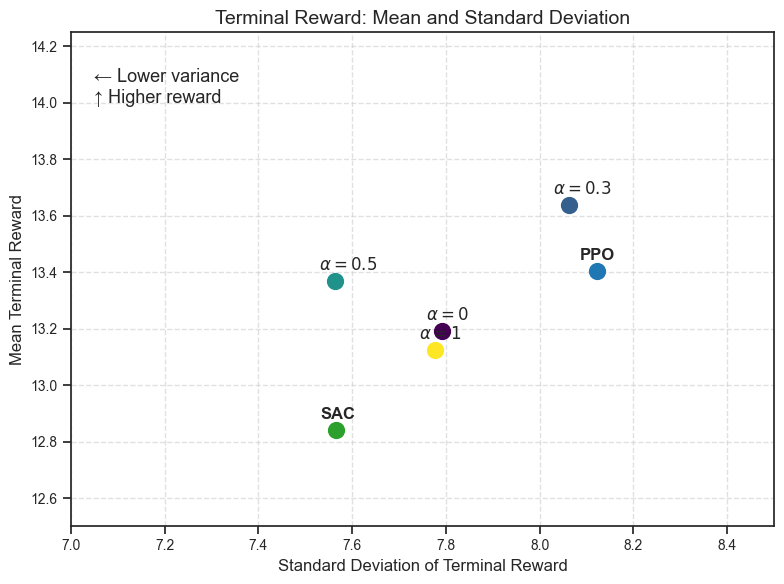

In [ ]:
# Set Metric to be the index
if "Metric" in am_copy.columns:
    am_copy.set_index("Metric", inplace=True)

# Extract data
x1 = am_copy.loc['std_terminal_reward']
y1 = am_copy.loc['mean_terminal_reward']

# Auto-detect model keys that look like alpha values (e.g., "α = 0.3")
alpha_like_models = [m for m in am_copy.columns if "=" in str(m)]

# Generate colormap only if alpha-like models are present
if alpha_like_models:
    # Extract numeric α values from model labels
    alpha_vals = [float(str(m).split('=')[1].strip().split('$')[0]) for m in alpha_like_models]
    norm = mcolors.Normalize(vmin=min(alpha_vals), vmax=max(alpha_vals))
    cmap = cm.viridis
    model_colors = {
        m: cmap(norm(float(str(m).split('=')[1].strip().split('$')[0]))) for m in alpha_like_models
    }
else:
    model_colors = {}

# Manual color fallbacks for known models
static_colors = {
    "PPO": "#1f77b4",
    "SAC": "#2ca02c",
    "Avellaneda-Stoikov": "#ff7f0e",
    "A2C": "#d62728"
}

# Create figure
plt.figure(figsize=(8, 6))
for model in am_copy.columns:
    color = model_colors.get(model, static_colors.get(model, 'gray'))
    plt.scatter(x1[model], y1[model], label=model, color=color, s=130)
    plt.text(x1[model] - 0.035, y1[model] + 0.04, model, fontsize=12, fontweight='bold')

# Aesthetics
plt.xlabel("Standard Deviation of Terminal Reward", fontsize=12)
plt.ylabel("Mean Terminal Reward", fontsize=12)
plt.title("Terminal Reward: Mean and Standard Deviation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(7,8.5)
plt.ylim(12.5, 14.25)

plt.annotate("← Lower variance\n↑ Higher reward", xy=(7.05, 14.0), fontsize=13)

plt.tight_layout()
plt.show()

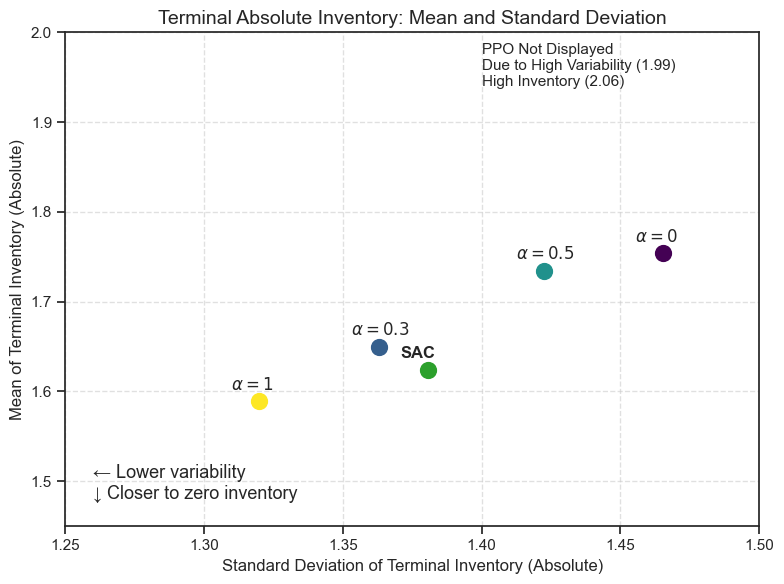

In [51]:
if 'PPO' in am_copy.columns:
    am_copy = am_copy.drop(columns=['PPO'])

# Extract data for second plot
x2 = am_copy.loc['std_abs_terminal_inventory']
y2 = am_copy.loc['mean_abs_terminal_inventory']

# Detect dynamic alpha-like models (e.g., "α = 0.3")
alpha_like_models = [m for m in am_copy.columns if "=" in str(m)]

if alpha_like_models:
    # Extract numerical values from strings like "α = 0.5", "$\\alpha = 0.5$", etc.
    alpha_vals = [float(re.findall(r"[-+]?\d*\.\d+|\d+", m)[0]) for m in alpha_like_models]
    
    norm = mcolors.Normalize(vmin=min(alpha_vals), vmax=max(alpha_vals))
    cmap = cm.viridis
    
    # Assign colors from colormap based on extracted α values
    model_colors = {
        m: cmap(norm(val)) for m, val in zip(alpha_like_models, alpha_vals)
    }
else:
    model_colors = {}

# Static color fallback for other models
static_colors = {
    "SAC": "#2ca02c",
    "Avellaneda-Stoikov": "#ff7f0e",
    "A2C": "#d62728"
}

# Plotting
plt.figure(figsize=(8, 6))
for model in am_copy.columns:
    color = model_colors.get(model, static_colors.get(model, 'gray'))
    plt.scatter(x2[model], y2[model], label=model, color=color, s=130)
    plt.text(x2[model] - 0.01, y2[model] + 0.013, model, fontsize=12, fontweight='bold')

# Axis labels
plt.xlabel("Standard Deviation of Terminal Inventory (Absolute)", fontsize=12)
plt.ylabel("Mean of Terminal Inventory (Absolute)", fontsize=12)

# Title
plt.title("Terminal Absolute Inventory: Mean and Standard Deviation", fontsize=14)

# Annotations
plt.annotate("← Lower variability\n↓ Closer to zero inventory", 
             xy=(1.26, 1.48), fontsize=13)

plt.annotate("PPO Not Displayed\nDue to High Variability (1.99)\nHigh Inventory (2.06)", 
             xy=(1.40, 1.94), fontsize=11)

# Axis limits and styling
plt.xlim(1.25, 1.5)
plt.ylim(1.45, 2.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Prepare data
df = pd.DataFrame({
    'Model': [model for model, values in all_agents_rewards_raw_series.items() for _ in values],
    'Reward': [val for values in all_agents_rewards_raw_series.values() for val in values]
})

# Latex-style relabeling
label_map = {
    'Alpha=0': r'$\alpha = 0$',
    'Alpha=0.3': r'$\alpha = 0.3$',
    'Alpha=0.5': r'$\alpha = 0.5$',
    'Alpha=1': r'$\alpha = 1$',
    'Avellaneda-Stoikov': r'Avellaneda-Stoikov'
}
df['Model'] = df['Model'].map(label_map)

# Formal font
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12
})

model_order = [r'$\alpha = 0$', r'$\alpha = 0.3$', r'$\alpha = 0.5$', r'$\alpha = 1$', r'Avellaneda-Stoikov']

# Create figure
plt.figure(figsize=(10, len(model_order) * 0.6), dpi=200)
sns.set_theme(style="whitegrid")

# Plot boxplots
sns.boxplot(
    data=df,
    y='Model',
    x='Reward',
    order=model_order,
    palette='Greys',
    width=0.5,
    showfliers=False,
    boxprops=dict(linewidth=1.2),
    medianprops=dict(color="black", linewidth=2)
)

# Plot *only outliers*
for model in model_order:
    rewards = df[df['Model'] == model]['Reward']
    q1 = rewards.quantile(0.25)
    q3 = rewards.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = rewards[(rewards < lower) | (rewards > upper)]
    y_pos = [model] * len(outliers)
    sns.stripplot(x=outliers, y=y_pos, color='black', size=3, alpha=0.6, jitter=True)

# Labels
plt.title('Reward Distribution by Model', fontsize=14, weight='bold', fontdict={'family': 'serif'})
plt.xlabel('Reward', fontsize=12, fontdict={'family': 'serif'}, weight='demibold')
plt.ylabel('Model', fontsize=12, fontdict={'family': 'serif'}, weight='demibold')
plt.xlim(-25, 55)
plt.tight_layout()
plt.show()

print("True Minimum for the AS agent: ", min(all_agents_rewards_raw_series["Avellaneda-Stoikov"]))
print("1th percentile for the AS agent: ", np.percentile(all_agents_rewards_raw_series["Avellaneda-Stoikov"], 1))

Seed in this run:  6523704


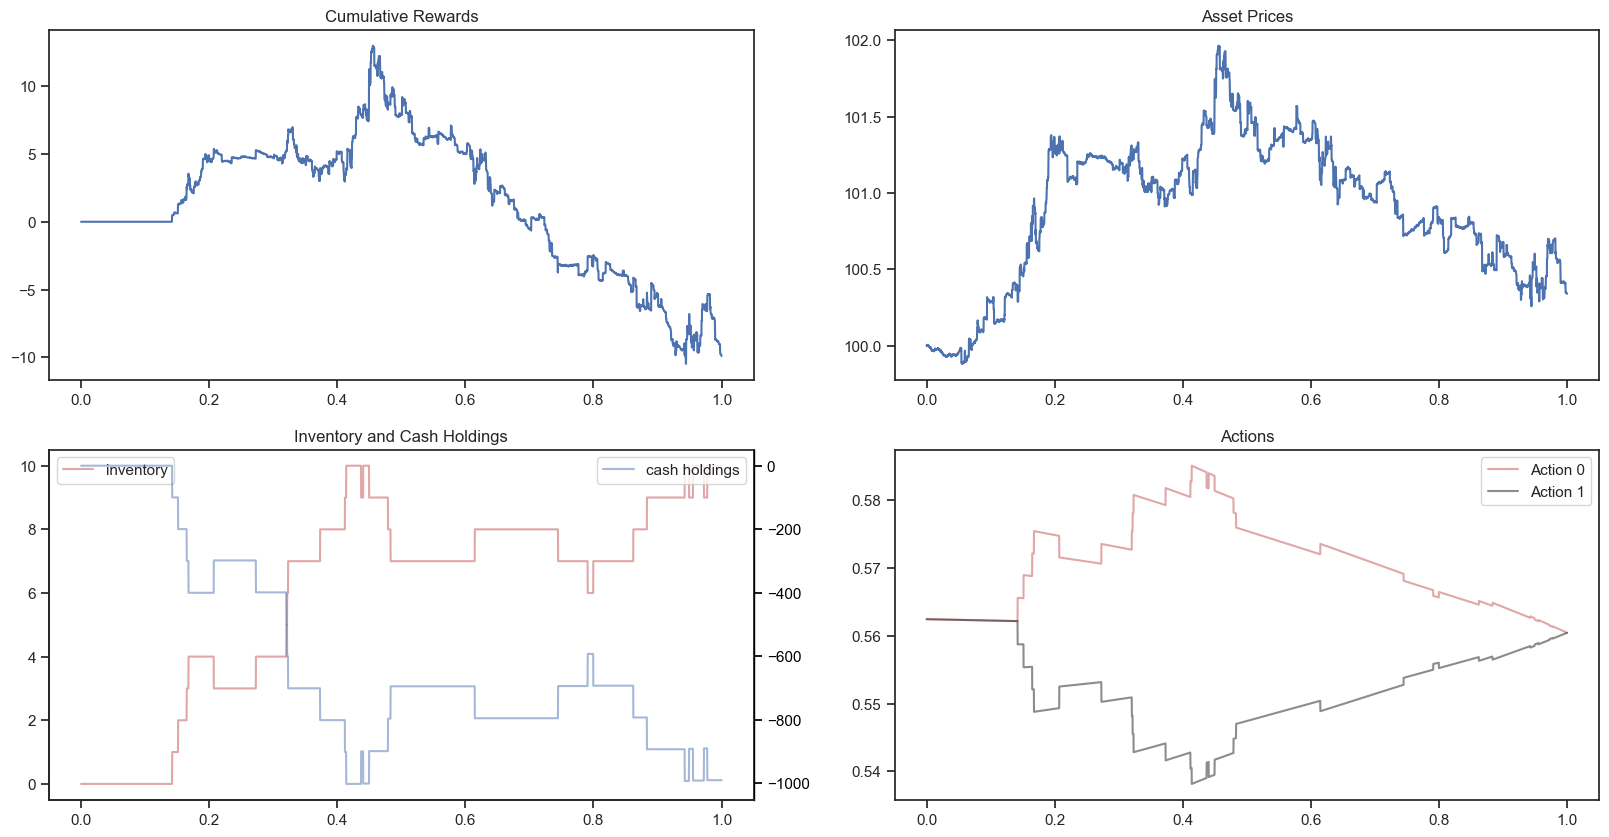

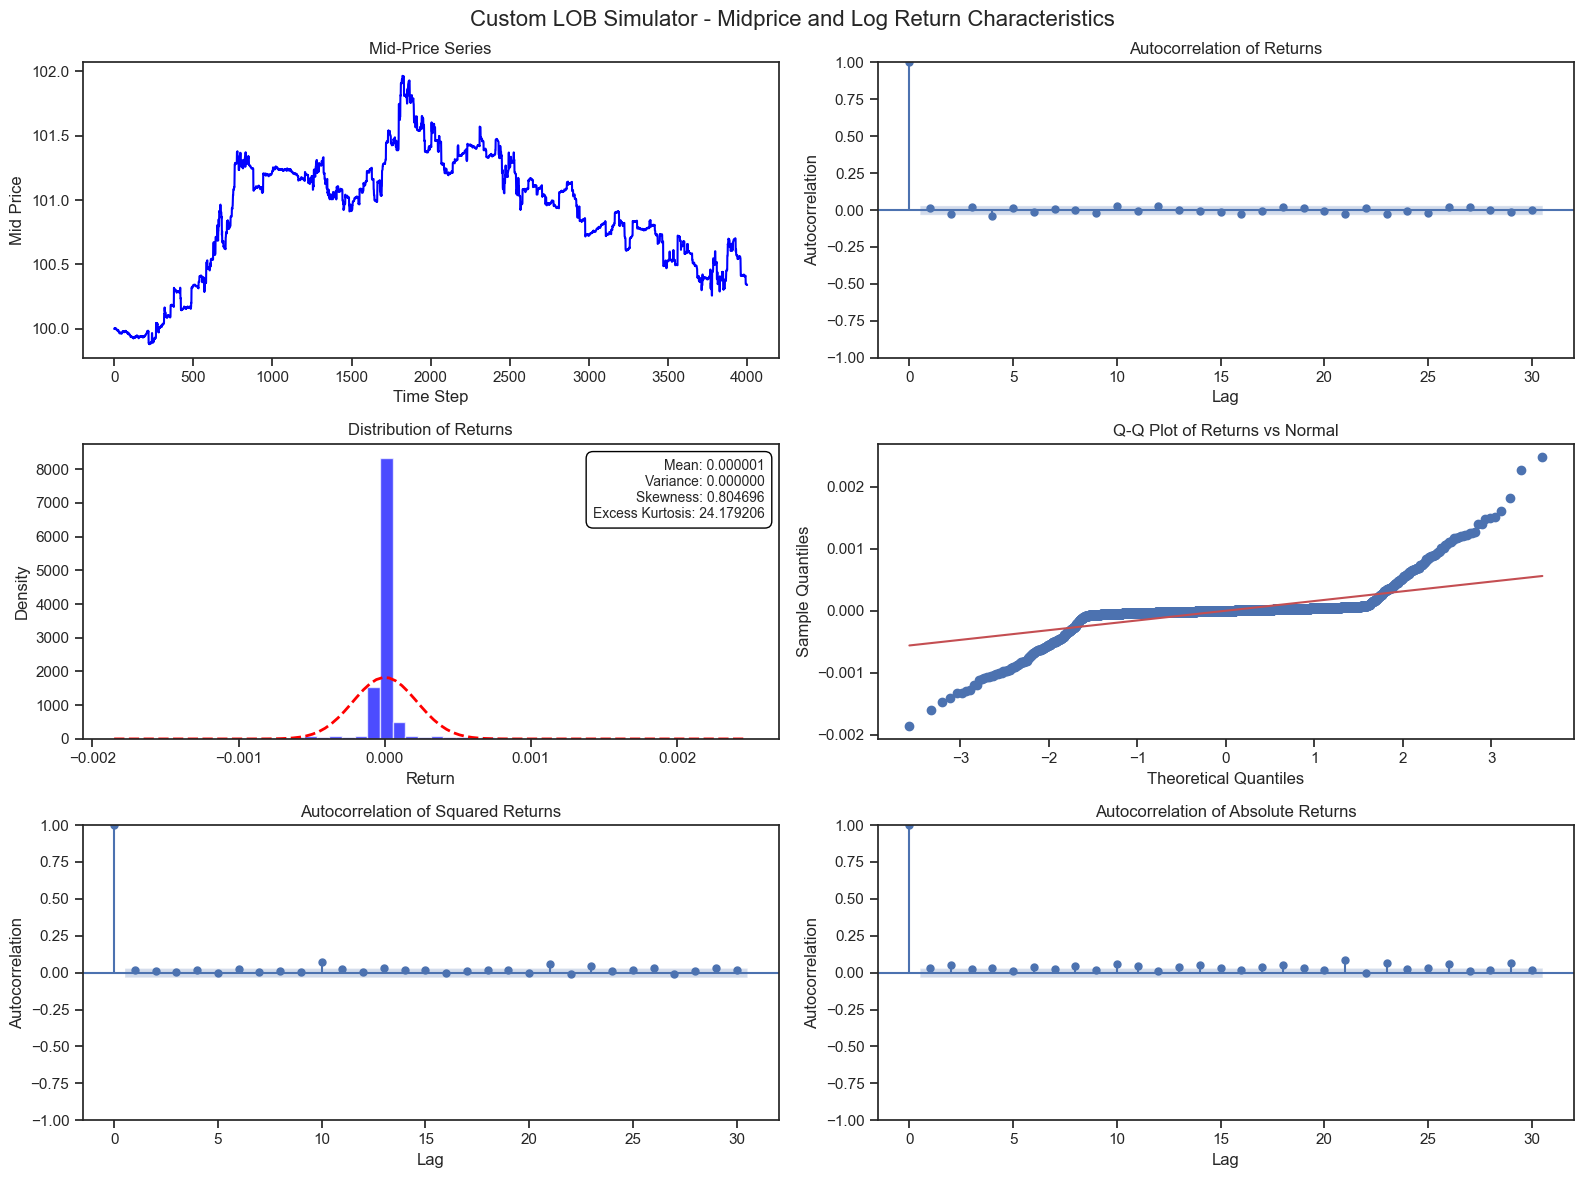

In [ ]:
# PLOT for AS Agent
seed = np.random.randint(0, 10000000)
print("Seed in this run: ", seed)

my_env = get_env_myModel()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=my_env)

as_mid_series_my, _ = plot_trajectory(my_env, as_agent, seed = seed)
visualize_return(as_mid_series_my, "Custom LOB Simulator - Midprice and Log Return Characteristics")

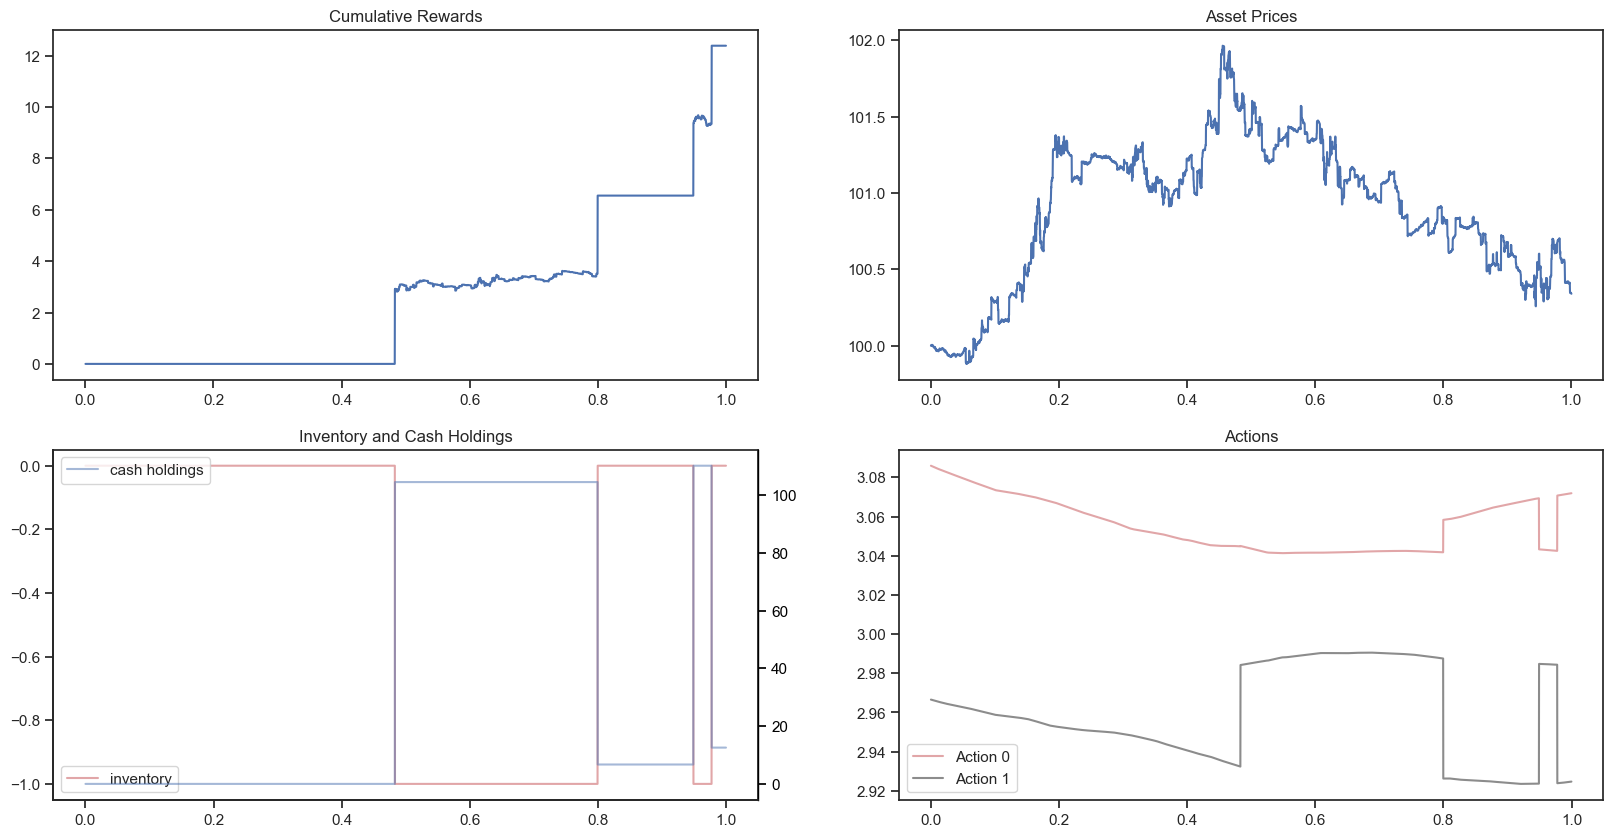

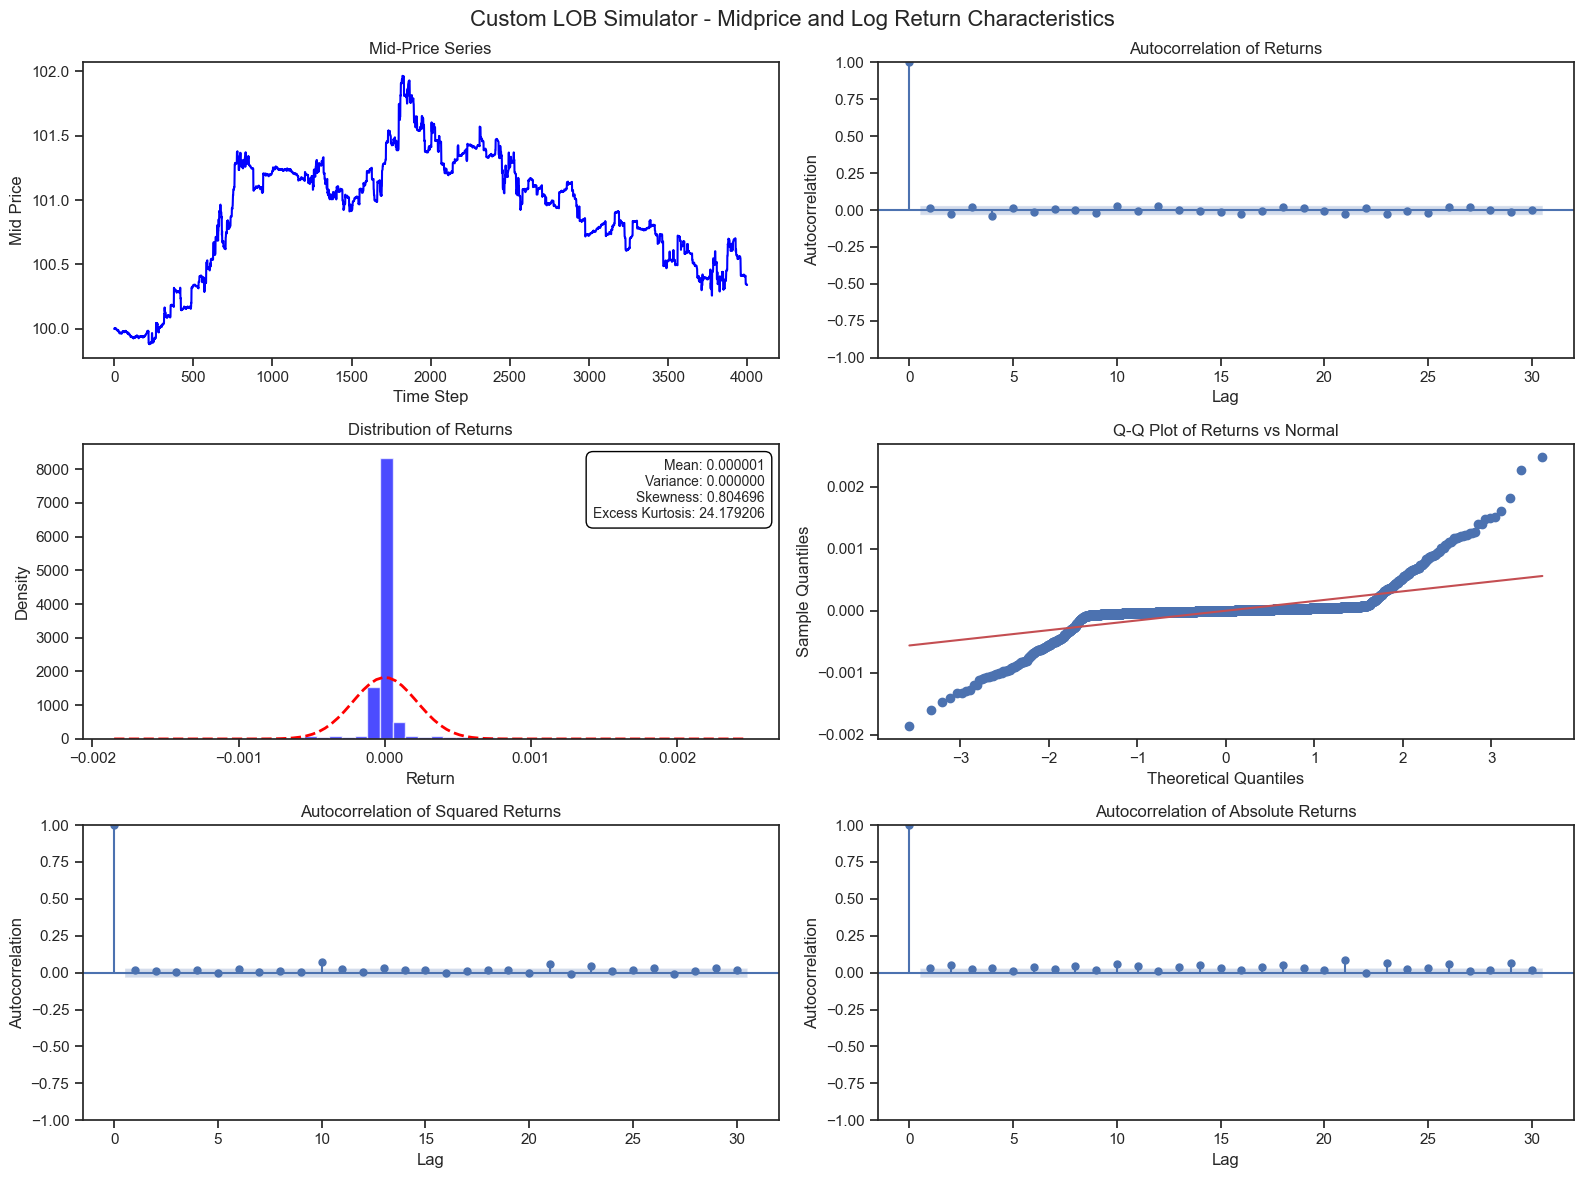

In [134]:
# PLOT For RL Agent

sac_agent = SbAgent(best_sac_model, num_trajectories=1, reduced_training_indices=[INVENTORY_INDEX, TIME_INDEX])

sac_mid_series_my, _ = plot_trajectory(my_env, sac_agent, seed = seed)

visualize_return(sac_mid_series_my, "Custom LOB Simulator - Midprice and Log Return Characteristics")